#### Buoyancy distributions at MCS phases for different duration types
- errorplots: short (5-12hr), medium (12-24hr), long duration (> 24hr)

In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def get_files_HCC(year, corr_temp_cri, corr_space_cri):
    
    data = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))

    corr_coeff_temp = data.corr_coeff_temp
    corr_coeff_space = data.corr_coeff_space.mean('mcs_phase')

    cond_1 = corr_coeff_temp > corr_temp_cri
    cond_2 = corr_coeff_space > corr_space_cri
    track_sel = data.isel(tracks=np.where(cond_1 & cond_2)[0]).tracks

    files_HCC = []
    for track in track_sel.values:
        files_HCC.extend(sorted(list(dir_envs_track.glob('mcs_era5_3D_envs_{}.{}.LD.nc'.format(year
                                                                    , str(track).zfill(5))))))
    return files_HCC

In [4]:
def get_files_duration(year, duration_min, duration_max):

    data = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))

    mcs_duration = data.mcs_duration

    cond_1 = mcs_duration >= duration_min
    cond_2 = mcs_duration < duration_max
    track_sel = data.isel(tracks=np.where(cond_1 & cond_2)[0]).tracks

    files_HCC = []
    for track in track_sel.values:
        files_HCC.extend(sorted(list(dir_envs_track.glob('mcs_era5_3D_envs_{}.{}.LD.nc'.format(year
                                                                    , str(track).zfill(5))))))
    return files_HCC

In [5]:
def buoyancy_dist_phases(fid_envs_track):

    data = xr.open_dataset(fid_envs_track) # get selected variables
    # BL associated with mcs / non-mcs grids
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    data_mcs = data.where(mcs_mask > 0)

    sp = data_mcs.SP/100

    thetae_bl = data_mcs.thetae_bl
    thetae_sat_lt = data_mcs.thetae_sat_lt
    thetae_lt = data_mcs.thetae_lt

    delta_pl=sp-100-500 # top at 500hPa
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb

    # calculate buoyancy estimate
    Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
    Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
    Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT # degree Kelvin (K)

    # save into lists for MCS phases
    BL_init = Buoy_TOT.sel(mcs_phase='Init').values
    BL_init = BL_init[~np.isnan(BL_init)]
    BL_grow = Buoy_TOT.sel(mcs_phase='Grow').values
    BL_grow = BL_grow[~np.isnan(BL_grow)]
    BL_mature = Buoy_TOT.sel(mcs_phase='Mature').values
    BL_mature = BL_mature[~np.isnan(BL_mature)]
    BL_decay = Buoy_TOT.sel(mcs_phase='Decay').values
    BL_decay = BL_decay[~np.isnan(BL_decay)]
    BL_end = Buoy_TOT.sel(mcs_phase='End').values
    BL_end = BL_end[~np.isnan(BL_end)]
    
    return (BL_init, BL_grow, BL_mature, BL_decay, BL_end)

In [6]:
def buoyancy_dist_phases_CAPE(fid_envs_track):

    data = xr.open_dataset(fid_envs_track) # get selected variables
    # BL associated with mcs / non-mcs grids
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    data_mcs = data.where(mcs_mask > 0)

    sp = data_mcs.SP/100

    thetae_bl = data_mcs.thetae_bl
    thetae_sat_lt = data_mcs.thetae_sat_lt
    thetae_lt = data_mcs.thetae_lt

    delta_pl=sp-100-500 # top at 500hPa
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb

    # calculate buoyancy estimate
    Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
    Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
    Buoy_TOT = Buoy_CAPE # degree Kelvin (K)

    # save into lists for MCS phases
    BL_init = Buoy_TOT.sel(mcs_phase='Init').values
    BL_init = BL_init[~np.isnan(BL_init)]
    BL_grow = Buoy_TOT.sel(mcs_phase='Grow').values
    BL_grow = BL_grow[~np.isnan(BL_grow)]
    BL_mature = Buoy_TOT.sel(mcs_phase='Mature').values
    BL_mature = BL_mature[~np.isnan(BL_mature)]
    BL_decay = Buoy_TOT.sel(mcs_phase='Decay').values
    BL_decay = BL_decay[~np.isnan(BL_decay)]
    BL_end = Buoy_TOT.sel(mcs_phase='End').values
    BL_end = BL_end[~np.isnan(BL_end)]
    
    return (BL_init, BL_grow, BL_mature, BL_decay, BL_end)

In [7]:
def buoyancy_dist_phases_SUBSAT(fid_envs_track):

    data = xr.open_dataset(fid_envs_track) # get selected variables
    # BL associated with mcs / non-mcs grids
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    data_mcs = data.where(mcs_mask > 0)

    sp = data_mcs.SP/100

    thetae_bl = data_mcs.thetae_bl
    thetae_sat_lt = data_mcs.thetae_sat_lt
    thetae_lt = data_mcs.thetae_lt

    delta_pl=sp-100-500 # top at 500hPa
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb

    # calculate buoyancy estimate
    Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
    Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
    Buoy_TOT = Buoy_SUBSAT # degree Kelvin (K)

    # save into lists for MCS phases
    BL_init = Buoy_TOT.sel(mcs_phase='Init').values
    BL_init = BL_init[~np.isnan(BL_init)]
    BL_grow = Buoy_TOT.sel(mcs_phase='Grow').values
    BL_grow = BL_grow[~np.isnan(BL_grow)]
    BL_mature = Buoy_TOT.sel(mcs_phase='Mature').values
    BL_mature = BL_mature[~np.isnan(BL_mature)]
    BL_decay = Buoy_TOT.sel(mcs_phase='Decay').values
    BL_decay = BL_decay[~np.isnan(BL_decay)]
    BL_end = Buoy_TOT.sel(mcs_phase='End').values
    BL_end = BL_end[~np.isnan(BL_end)]
    
    return (BL_init, BL_grow, BL_mature, BL_decay, BL_end)

In [34]:
%%time
# separate by mcs duration groups

year_list = np.arange(2001,2021)

########  parameters for filtering MCS tracks  ########
corr_temp_cri = 0.7 # temporal correlation between the mean values of ERA-5 and GPM precip during the evolution
corr_space_cri = -999. # mean spatial correlation between ERA-5 and GPM precip. 2-D maps during the evolution
sampling_opt = 'all' # MCS geolocation: 'all','ocean','land'
######################################################33

print('corre_temp_cri: {}'.format(corr_temp_cri))
print('corre_space_cri: {}'.format(corr_space_cri))
print('sampling_opt: {}'.format(sampling_opt))

mcs_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
featstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')

BL_init_dtypes = []
BL_grow_dtypes = []
BL_mature_dtypes = []
BL_decay_dtypes = []
BL_end_dtypes = []

for (dmin, dmax, duration_type) in zip([5,6,12,18,24],[6,12,18,24,200],
                                       ['SL','ML','LL','UL','UUL']):
    files_multiyr = []
    for year in year_list[::3]:
        
        dir_envs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend/'.format(year))
        # grouping by high temporal correlation
        files_HCC = get_files_HCC(year, corr_temp_cri, corr_space_cri)
        # grouping by MCS duration
        files_duration = get_files_duration(year, duration_min=dmin, duration_max=dmax) 
        files_tmp = list(set(files_HCC).intersection(files_duration))
        files_multiyr.extend(files_tmp)
        
    print('number of selected tracks during {}-{}: {}'.format(year_list[0],year_list[-1],len(files_multiyr)))

    ########## loops for tracks of one specified duration type
    BL_init = []
    BL_grow = []
    BL_mature = []
    BL_decay = []
    BL_end = []
    
    for file in files_multiyr:
        output = buoyancy_dist_phases(file)
        BL_init.extend(output[0])
        BL_grow.extend(output[1])
        BL_mature.extend(output[2])
        BL_decay.extend(output[3])
        BL_end.extend(output[4])
    ############################################

    BL_init_dtypes.append(BL_init)
    BL_grow_dtypes.append(BL_grow)
    BL_mature_dtypes.append(BL_mature)
    BL_decay_dtypes.append(BL_decay)
    BL_end_dtypes.append(BL_end)

# writeout 
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')
np.save(out_dir / 'BLTOT_init_dtypes.TempCorr0.7.npy', BL_init_dtypes)
np.save(out_dir / 'BLTOT_grow_dtypes.TempCorr0.7.npy', BL_grow_dtypes)
np.save(out_dir / 'BLTOT_mature_dtypes.TempCorr0.7.npy', BL_mature_dtypes)
np.save(out_dir / 'BLTOT_decay_dtypes.TempCorr0.7.npy', BL_decay_dtypes)
np.save(out_dir / 'BLTOT_end_dtypes.TempCorr0.7.npy', BL_end_dtypes)

corre_temp_cri: 0.7
corre_space_cri: -999.0
sampling_opt: all
number of selected tracks during 2001-2020: 188
number of selected tracks during 2001-2020: 2526
number of selected tracks during 2001-2020: 1797
number of selected tracks during 2001-2020: 907
number of selected tracks during 2001-2020: 1126
CPU times: user 4min 57s, sys: 1min 25s, total: 6min 22s
Wall time: 6min 29s


In [35]:
%%time
# separate by mcs duration groups

year_list = np.arange(2001,2021)

########  parameters for filtering MCS tracks  ########
corr_temp_cri = 0.7 # temporal correlation between the mean values of ERA-5 and GPM precip during the evolution
corr_space_cri = -999. # mean spatial correlation between ERA-5 and GPM precip. 2-D maps during the evolution
sampling_opt = 'all' # MCS geolocation: 'all','ocean','land'
######################################################33

print('corre_temp_cri: {}'.format(corr_temp_cri))
print('corre_space_cri: {}'.format(corr_space_cri))
print('sampling_opt: {}'.format(sampling_opt))

mcs_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
featstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')

BCAPE_init_dtypes = []
BCAPE_grow_dtypes = []
BCAPE_mature_dtypes = []
BCAPE_decay_dtypes = []
BCAPE_end_dtypes = []

for (dmin, dmax, duration_type) in zip([5,6,12,18,24],[6,12,18,24,200],
                                       ['SL','ML','LL','UL','UUL']):
    files_multiyr = []
    for year in year_list[::3]:
        
        dir_envs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend/'.format(year))
        # grouping by high temporal correlation
        files_HCC = get_files_HCC(year, corr_temp_cri, corr_space_cri)
        # grouping by MCS duration
        files_duration = get_files_duration(year, duration_min=dmin, duration_max=dmax) 
        files_tmp = list(set(files_HCC).intersection(files_duration))
        files_multiyr.extend(files_tmp)
        
    print('number of selected tracks during {}-{}: {}'.format(year_list[0],year_list[-1],len(files_multiyr)))

    ########## loops for tracks of one specified duration type
    BL_init = []
    BL_grow = []
    BL_mature = []
    BL_decay = []
    BL_end = []
    
    for file in files_multiyr:
        output = buoyancy_dist_phases_CAPE(file)
        BL_init.extend(output[0])
        BL_grow.extend(output[1])
        BL_mature.extend(output[2])
        BL_decay.extend(output[3])
        BL_end.extend(output[4])
    ############################################

    BCAPE_init_dtypes.append(BL_init)
    BCAPE_grow_dtypes.append(BL_grow)
    BCAPE_mature_dtypes.append(BL_mature)
    BCAPE_decay_dtypes.append(BL_decay)
    BCAPE_end_dtypes.append(BL_end)

# writeout 
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')
np.save(out_dir / 'BLCAPE_init_dtypes.TempCorr0.7.npy', BCAPE_init_dtypes)
np.save(out_dir / 'BLCAPE_grow_dtypes.TempCorr0.7.npy', BCAPE_grow_dtypes)
np.save(out_dir / 'BLCAPE_mature_dtypes.TempCorr0.7.npy', BCAPE_mature_dtypes)
np.save(out_dir / 'BLCAPE_decay_dtypes.TempCorr0.7.npy', BCAPE_decay_dtypes)
np.save(out_dir / 'BLCAPE_end_dtypes.TempCorr0.7.npy', BCAPE_end_dtypes)

corre_temp_cri: 0.7
corre_space_cri: -999.0
sampling_opt: all
number of selected tracks during 2001-2020: 188
number of selected tracks during 2001-2020: 2526
number of selected tracks during 2001-2020: 1797
number of selected tracks during 2001-2020: 907
number of selected tracks during 2001-2020: 1126
CPU times: user 2min 18s, sys: 36.1 s, total: 2min 54s
Wall time: 2min 57s


In [36]:
%%time
# separate by mcs duration groups

year_list = np.arange(2001,2021)

########  parameters for filtering MCS tracks  ########
corr_temp_cri = 0.7 # temporal correlation between the mean values of ERA-5 and GPM precip during the evolution
corr_space_cri = -999. # mean spatial correlation between ERA-5 and GPM precip. 2-D maps during the evolution
sampling_opt = 'all' # MCS geolocation: 'all','ocean','land'
######################################################33

print('corre_temp_cri: {}'.format(corr_temp_cri))
print('corre_space_cri: {}'.format(corr_space_cri))
print('sampling_opt: {}'.format(sampling_opt))

mcs_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
featstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')

BSUB_init_dtypes = []
BSUB_grow_dtypes = []
BSUB_mature_dtypes = []
BSUB_decay_dtypes = []
BSUB_end_dtypes = []

for (dmin, dmax, duration_type) in zip([5,6,12,18,24],[6,12,18,24,200],
                                       ['SL','ML','LL','UL','UUL']):
    files_multiyr = []
    for year in year_list[::3]:
        
        dir_envs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend/'.format(year))
        # grouping by high temporal correlation
        files_HCC = get_files_HCC(year, corr_temp_cri, corr_space_cri)
        # grouping by MCS duration
        files_duration = get_files_duration(year, duration_min=dmin, duration_max=dmax) 
        files_tmp = list(set(files_HCC).intersection(files_duration))
        files_multiyr.extend(files_tmp)
        
    print('number of selected tracks during {}-{}: {}'.format(year_list[0],year_list[-1],len(files_multiyr)))

    ########## loops for tracks of one specified duration type
    BL_init = []
    BL_grow = []
    BL_mature = []
    BL_decay = []
    BL_end = []
    
    for file in files_multiyr:
        output = buoyancy_dist_phases_SUBSAT(file)
        BL_init.extend(output[0])
        BL_grow.extend(output[1])
        BL_mature.extend(output[2])
        BL_decay.extend(output[3])
        BL_end.extend(output[4])
    ############################################

    BSUB_init_dtypes.append(BL_init)
    BSUB_grow_dtypes.append(BL_grow)
    BSUB_mature_dtypes.append(BL_mature)
    BSUB_decay_dtypes.append(BL_decay)
    BSUB_end_dtypes.append(BL_end)

# writeout 
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')
np.save(out_dir / 'BLSUBSAT_init_dtypes.TempCorr0.7.npy', BSUB_init_dtypes)
np.save(out_dir / 'BLSUBSAT_grow_dtypes.TempCorr0.7.npy', BSUB_grow_dtypes)
np.save(out_dir / 'BLSUBSAT_mature_dtypes.TempCorr0.7.npy', BSUB_mature_dtypes)
np.save(out_dir / 'BLSUBSAT_decay_dtypes.TempCorr0.7.npy', BSUB_decay_dtypes)
np.save(out_dir / 'BLSUBSAT_end_dtypes.TempCorr0.7.npy', BSUB_end_dtypes)

corre_temp_cri: 0.7
corre_space_cri: -999.0
sampling_opt: all
number of selected tracks during 2001-2020: 188
number of selected tracks during 2001-2020: 2526
number of selected tracks during 2001-2020: 1797
number of selected tracks during 2001-2020: 907
number of selected tracks during 2001-2020: 1126
CPU times: user 2min 18s, sys: 36.3 s, total: 2min 55s
Wall time: 2min 57s


#### area of buoyancy exceeding BL,crit

In [24]:
def Buoycrit_area_phases(fid_envs_track):

    data = xr.open_dataset(fid_envs_track) # get selected variables
    # BL associated with mcs / non-mcs grids
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    data_mcs = data.where(mcs_mask > 0)

    sp = data_mcs.SP/100

    thetae_bl = data_mcs.thetae_bl
    thetae_sat_lt = data_mcs.thetae_sat_lt
    thetae_lt = data_mcs.thetae_lt

    delta_pl=sp-100-500 # top at 500hPa
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb

    # calculate buoyancy estimate
    Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
    Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
    Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT # degree Kelvin (K)

    Buoycrit_area = Buoy_TOT.where(Buoy_TOT > -5, 0)
    Buoycrit_area = Buoycrit_area.where(Buoycrit_area == 0, 1)
    Buoycrit_area = 25*25*Buoycrit_area.sum(('x','y')) # km^2

    # save into lists for MCS phases
    BL_init = Buoycrit_area.sel(mcs_phase='Init').values
    BL_init = BL_init[~np.isnan(BL_init)]
    BL_grow = Buoycrit_area.sel(mcs_phase='Grow').values
    BL_grow = BL_grow[~np.isnan(BL_grow)]
    BL_mature = Buoycrit_area.sel(mcs_phase='Mature').values
    BL_mature = BL_mature[~np.isnan(BL_mature)]
    BL_decay = Buoycrit_area.sel(mcs_phase='Decay').values
    BL_decay = BL_decay[~np.isnan(BL_decay)]
    BL_end = Buoycrit_area.sel(mcs_phase='End').values
    BL_end = BL_end[~np.isnan(BL_end)]
    
    return (BL_init, BL_grow, BL_mature, BL_decay, BL_end)

In [37]:
%%time
# separate by mcs duration groups

year_list = np.arange(2001,2021)

########  parameters for filtering MCS tracks  ########
corr_temp_cri = 0.7 # temporal correlation between the mean values of ERA-5 and GPM precip during the evolution
corr_space_cri = -999. # mean spatial correlation between ERA-5 and GPM precip. 2-D maps during the evolution
sampling_opt = 'all' # MCS geolocation: 'all','ocean','land'
######################################################33

print('corre_temp_cri: {}'.format(corr_temp_cri))
print('corre_space_cri: {}'.format(corr_space_cri))
print('sampling_opt: {}'.format(sampling_opt))

mcs_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
featstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')

BAREA_init_dtypes = []
BAREA_grow_dtypes = []
BAREA_mature_dtypes = []
BAREA_decay_dtypes = []
BAREA_end_dtypes = []

for (dmin, dmax, duration_type) in zip([5,6,12,18,24],[6,12,18,24,200],
                                       ['SL','ML','LL','UL','UUL']):
    files_multiyr = []
    for year in year_list[::3]:
        
        dir_envs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend/'.format(year))
        # grouping by high temporal correlation
        files_HCC = get_files_HCC(year, corr_temp_cri, corr_space_cri)
        # grouping by MCS duration
        files_duration = get_files_duration(year, duration_min=dmin, duration_max=dmax) 
        files_tmp = list(set(files_HCC).intersection(files_duration))
        files_multiyr.extend(files_tmp)
        
    print('number of selected tracks during {}-{}: {}'.format(year_list[0],year_list[-1],len(files_multiyr)))

    ########## loops for tracks of one specified duration type
    BL_init = []
    BL_grow = []
    BL_mature = []
    BL_decay = []
    BL_end = []
    
    for file in files_multiyr:
        output = Buoycrit_area_phases(file)
        BL_init.extend(output[0])
        BL_grow.extend(output[1])
        BL_mature.extend(output[2])
        BL_decay.extend(output[3])
        BL_end.extend(output[4])
    ############################################

    BAREA_init_dtypes.append(BL_init)
    BAREA_grow_dtypes.append(BL_grow)
    BAREA_mature_dtypes.append(BL_mature)
    BAREA_decay_dtypes.append(BL_decay)
    BAREA_end_dtypes.append(BL_end)

# writeout 
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')
np.save(out_dir / 'BCAREA_init_dtypes.TempCorr0.7.npy', BAREA_init_dtypes)
np.save(out_dir / 'BCAREA_grow_dtypes.TempCorr0.7.npy', BAREA_grow_dtypes)
np.save(out_dir / 'BCAREA_mature_dtypes.TempCorr0.7.npy', BAREA_mature_dtypes)
np.save(out_dir / 'BCAREA_decay_dtypes.TempCorr0.7.npy', BAREA_decay_dtypes)
np.save(out_dir / 'BCAREA_end_dtypes.TempCorr0.7.npy', BAREA_end_dtypes)

corre_temp_cri: 0.7
corre_space_cri: -999.0
sampling_opt: all
number of selected tracks during 2001-2020: 188
number of selected tracks during 2001-2020: 2526
number of selected tracks during 2001-2020: 1797
number of selected tracks during 2001-2020: 907
number of selected tracks during 2001-2020: 1126
CPU times: user 2min 14s, sys: 36.4 s, total: 2min 51s
Wall time: 2min 53s


#### area of the largest precipitating feature

In [ ]:
def PF_area_phases(fid_envs_track):

    data = xr.open_dataset(fid_envs_track) # get selected variables
    # BL associated with mcs / non-mcs grids
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    data_mcs = data.where(mcs_mask > 0)

    sp = data_mcs.SP/100

    thetae_bl = data_mcs.thetae_bl
    thetae_sat_lt = data_mcs.thetae_sat_lt
    thetae_lt = data_mcs.thetae_lt

    delta_pl=sp-100-500 # top at 500hPa
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb

    # calculate buoyancy estimate
    Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
    Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
    Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT # degree Kelvin (K)

    Buoycrit_area = Buoy_TOT.where(Buoy_TOT > -5, 0)
    Buoycrit_area = Buoycrit_area.where(Buoycrit_area == 0, 1)
    Buoycrit_area = 25*25*Buoycrit_area.sum(('x','y')) # km^2

    # save into lists for MCS phases
    BL_init = Buoycrit_area.sel(mcs_phase='Init').values
    BL_init = BL_init[~np.isnan(BL_init)]
    BL_grow = Buoycrit_area.sel(mcs_phase='Grow').values
    BL_grow = BL_grow[~np.isnan(BL_grow)]
    BL_mature = Buoycrit_area.sel(mcs_phase='Mature').values
    BL_mature = BL_mature[~np.isnan(BL_mature)]
    BL_decay = Buoycrit_area.sel(mcs_phase='Decay').values
    BL_decay = BL_decay[~np.isnan(BL_decay)]
    BL_end = Buoycrit_area.sel(mcs_phase='End').values
    BL_end = BL_end[~np.isnan(BL_end)]
    
    return (BL_init, BL_grow, BL_mature, BL_decay, BL_end)

In [ ]:
%%time
# separate by mcs duration groups

year_list = np.arange(2001,2021)

########  parameters for filtering MCS tracks  ########
corr_temp_cri = -999. # temporal correlation between the mean values of ERA-5 and GPM precip during the evolution
corr_space_cri = -999. # mean spatial correlation between ERA-5 and GPM precip. 2-D maps during the evolution
sampling_opt = 'all' # MCS geolocation: 'all','ocean','land'
######################################################33

print('corre_temp_cri: {}'.format(corr_temp_cri))
print('corre_space_cri: {}'.format(corr_space_cri))
print('sampling_opt: {}'.format(sampling_opt))

mcs_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
featstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')

PFAREA_init_dtypes = []
PFAREA_grow_dtypes = []
PFAREA_mature_dtypes = []
PFAREA_decay_dtypes = []
PFAREA_end_dtypes = []

for (dmin, dmax, duration_type) in zip([5,6,12,18,24],[6,12,18,24,200],
                                       ['SL','ML','LL','UL','UUL']):
    files_multiyr = []
    for year in year_list[::3]:
        
        dir_envs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend/'.format(year))
        # grouping by high temporal correlation
        files_HCC = get_files_HCC(year, corr_temp_cri, corr_space_cri)
        # grouping by MCS duration
        files_duration = get_files_duration(year, duration_min=dmin, duration_max=dmax) 
        files_tmp = list(set(files_HCC).intersection(files_duration))
        files_multiyr.extend(files_tmp)
        
    print('number of selected tracks during {}-{}: {}'.format(year_list[0],year_list[-1],len(files_multiyr)))

    ########## loops for tracks of one specified duration type
    BL_init = []
    BL_grow = []
    BL_mature = []
    BL_decay = []
    BL_end = []
    
    for file in files_multiyr:
        output = PF_area_phases(file)
        BL_init.extend(output[0])
        BL_grow.extend(output[1])
        BL_mature.extend(output[2])
        BL_decay.extend(output[3])
        BL_end.extend(output[4])
    ############################################

    PFAREA_init_dtypes.append(BL_init)
    PFAREA_grow_dtypes.append(BL_grow)
    PFAREA_mature_dtypes.append(BL_mature)
    PFAREA_decay_dtypes.append(BL_decay)
    PFAREA_end_dtypes.append(BL_end)

# writeout 
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')
np.save(out_dir / 'PFAREA_init_dtypes.npy', PFAREA_init_dtypes)
np.save(out_dir / 'PFAREA_grow_dtypes.npy', PFAREA_grow_dtypes)
np.save(out_dir / 'PFAREA_mature_dtypes.npy', PFAREA_mature_dtypes)
np.save(out_dir / 'PFAREA_decay_dtypes.npy', PFAREA_decay_dtypes)
np.save(out_dir / 'PFAREA_end_dtypes.npy', PFAREA_end_dtypes)

#### plotting section 

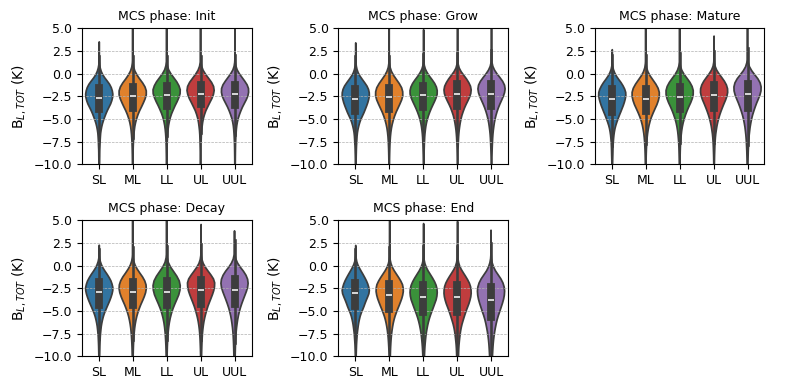

In [41]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')

BL_init_dtypes = np.load(out_dir / 'BLTOT_init_dtypes.npy', allow_pickle=True).tolist()
BL_grow_dtypes = np.load(out_dir / 'BLTOT_grow_dtypes.npy', allow_pickle=True).tolist()
BL_mature_dtypes = np.load(out_dir / 'BLTOT_mature_dtypes.npy', allow_pickle=True).tolist()
BL_decay_dtypes = np.load(out_dir / 'BLTOT_decay_dtypes.npy', allow_pickle=True).tolist()
BL_end_dtypes = np.load(out_dir / 'BLTOT_end_dtypes.npy', allow_pickle=True).tolist()

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,4))

for (ax,data,phase) in zip([ax1,ax2,ax3,ax4,ax5],
                           [BL_init_dtypes, BL_grow_dtypes, BL_mature_dtypes,
                            BL_decay_dtypes, BL_end_dtypes],
                           ['Init','Grow','Mature','Decay','End']):

    sns.violinplot(data=data, ax=ax)
    ax.set_ylabel('B$_{L,TOT}$ (K)', fontsize=10)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['SL','ML','LL','UL','UUL']);
    ax.set_ylim([-10,5])
    ax.set_yticks([-10,-7.5,-5,-2.5,0,2.5,5])
    ax.grid(lw=0.5, ls='--', axis='y')
    ax.set_title('MCS phase: {}'.format(phase), fontsize=9)
    ax.tick_params(labelsize=9)
    
ax6.spines['bottom'].set_color('w')
ax6.spines['top'].set_color('w')
ax6.spines['left'].set_color('w')
ax6.spines['right'].set_color('w')
ax6.xaxis.label.set_color('w')
ax6.yaxis.label.set_color('w')
ax6.tick_params(axis='both', colors='w')

plt.tight_layout()

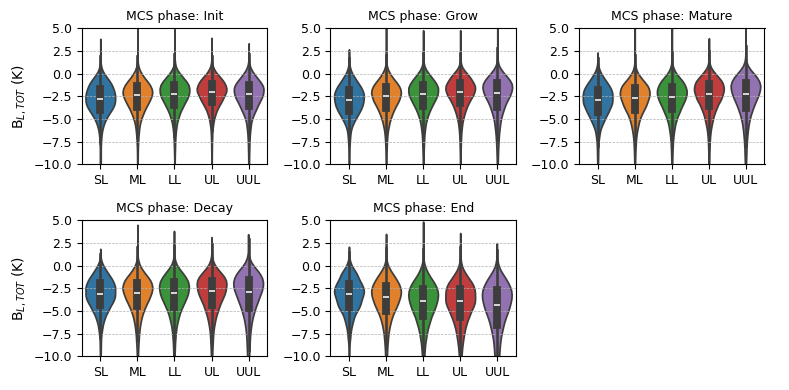

In [48]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')

BL_init_dtypes = np.load(out_dir / 'BLTOT_init_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()
BL_grow_dtypes = np.load(out_dir / 'BLTOT_grow_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()
BL_mature_dtypes = np.load(out_dir / 'BLTOT_mature_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()
BL_decay_dtypes = np.load(out_dir / 'BLTOT_decay_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()
BL_end_dtypes = np.load(out_dir / 'BLTOT_end_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,4))

for (ax,data,phase) in zip([ax1,ax2,ax3,ax4,ax5],
                           [BL_init_dtypes, BL_grow_dtypes, BL_mature_dtypes,
                            BL_decay_dtypes, BL_end_dtypes],
                           ['Init','Grow','Mature','Decay','End']):

    sns.violinplot(data=data, ax=ax)
    ax.set_ylabel('B$_{L,TOT}$ (K)', fontsize=10)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['SL','ML','LL','UL','UUL']);
    ax.set_ylim([-10,5])
    ax.set_yticks([-10,-7.5,-5,-2.5,0,2.5,5])
    ax.grid(lw=0.5, ls='--', axis='y')
    ax.set_title('MCS phase: {}'.format(phase), fontsize=9)
    ax.tick_params(labelsize=9)
    
ax6.spines['bottom'].set_color('w')
ax6.spines['top'].set_color('w')
ax6.spines['left'].set_color('w')
ax6.spines['right'].set_color('w')
ax6.xaxis.label.set_color('w')
ax6.yaxis.label.set_color('w')
ax6.tick_params(axis='both', colors='w')

ax2.set_ylabel('')
ax3.set_ylabel('')
ax5.set_ylabel('')

plt.tight_layout()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLTOT_phases_violin.pdf',
           bbox_inches='tight', transparent=False)

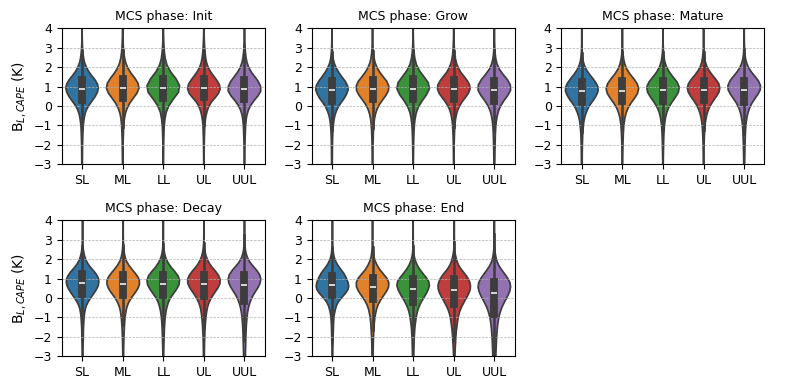

In [49]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')

BL_init_dtypes = np.load(out_dir / 'BLCAPE_init_dtypes.npy', allow_pickle=True).tolist()
BL_grow_dtypes = np.load(out_dir / 'BLCAPE_grow_dtypes.npy', allow_pickle=True).tolist()
BL_mature_dtypes = np.load(out_dir / 'BLCAPE_mature_dtypes.npy', allow_pickle=True).tolist()
BL_decay_dtypes = np.load(out_dir / 'BLCAPE_decay_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()
BL_end_dtypes = np.load(out_dir / 'BLCAPE_end_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,4))

for (ax,data,phase) in zip([ax1,ax2,ax3,ax4,ax5],
                           [BL_init_dtypes, BL_grow_dtypes, BL_mature_dtypes,
                            BL_decay_dtypes, BL_end_dtypes],
                           ['Init','Grow','Mature','Decay','End']):

    sns.violinplot(data=data, ax=ax)
    ax.set_ylabel('B$_{L,CAPE}$ (K)', fontsize=10)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['SL','ML','LL','UL','UUL']);
    ax.set_ylim([-2,4])
    ax.set_yticks([-3,-2,-1,0,1,2,3,4])
    ax.grid(lw=0.5, ls='--', axis='y')
    ax.set_title('MCS phase: {}'.format(phase), fontsize=9)
    ax.tick_params(labelsize=9)
    
ax6.spines['bottom'].set_color('w')
ax6.spines['top'].set_color('w')
ax6.spines['left'].set_color('w')
ax6.spines['right'].set_color('w')
ax6.xaxis.label.set_color('w')
ax6.yaxis.label.set_color('w')
ax6.tick_params(axis='both', colors='w')

ax2.set_ylabel('')
ax3.set_ylabel('')
ax5.set_ylabel('')

plt.tight_layout()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLCAPE_phases_violin.pdf',
           bbox_inches='tight', transparent=False)

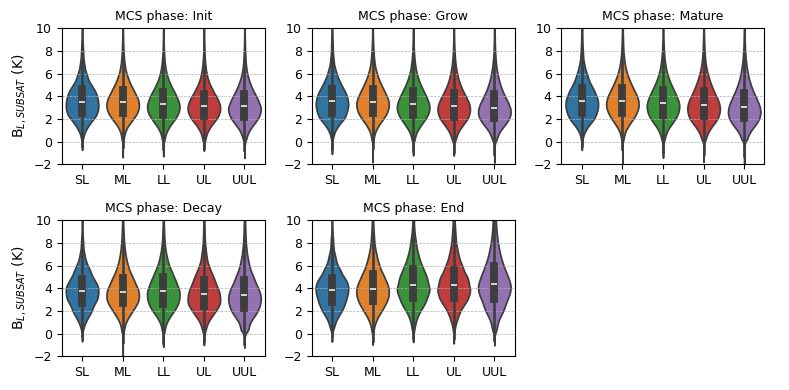

In [47]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/phases_violinplots')

BL_init_dtypes = np.load(out_dir / 'BLSUBSAT_init_dtypes.npy', allow_pickle=True).tolist()
BL_grow_dtypes = np.load(out_dir / 'BLSUBSAT_grow_dtypes.npy', allow_pickle=True).tolist()
BL_mature_dtypes = np.load(out_dir / 'BLSUBSAT_mature_dtypes.npy', allow_pickle=True).tolist()
BL_decay_dtypes = np.load(out_dir / 'BLSUBSAT_decay_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()
BL_end_dtypes = np.load(out_dir / 'BLSUBSAT_end_dtypes.TempCorr0.7.npy', allow_pickle=True).tolist()

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,4))

for (ax,data,phase) in zip([ax1,ax2,ax3,ax4,ax5],
                           [BL_init_dtypes, BL_grow_dtypes, BL_mature_dtypes,
                            BL_decay_dtypes, BL_end_dtypes],
                           ['Init','Grow','Mature','Decay','End']):

    sns.violinplot(data=data, ax=ax)
    ax.set_ylabel('B$_{L,SUBSAT}$ (K)', fontsize=10)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['SL','ML','LL','UL','UUL']);
    ax.set_ylim([-2,10])
    ax.set_yticks([-2,0,2,4,6,8,10])
    ax.grid(lw=0.5, ls='--', axis='y')
    ax.set_title('MCS phase: {}'.format(phase), fontsize=9)
    ax.tick_params(labelsize=9)
    
ax6.spines['bottom'].set_color('w')
ax6.spines['top'].set_color('w')
ax6.spines['left'].set_color('w')
ax6.spines['right'].set_color('w')
ax6.xaxis.label.set_color('w')
ax6.yaxis.label.set_color('w')
ax6.tick_params(axis='both', colors='w')

ax2.set_ylabel('')
ax3.set_ylabel('')
ax5.set_ylabel('')

plt.tight_layout()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLSUBSAT_phases_violin.pdf',
           bbox_inches='tight', transparent=False)

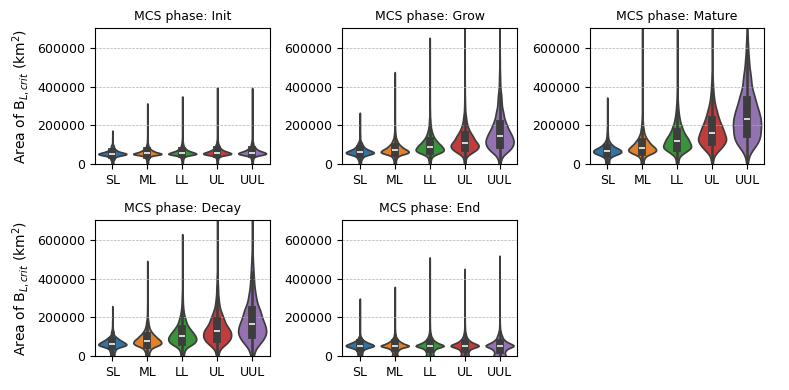

In [46]:
BAREA_init_dtypes = np.load(out_dir / 'BCAREA_init_dtypes.npy', allow_pickle=True).tolist()
BAREA_grow_dtypes = np.load(out_dir / 'BCAREA_grow_dtypes.npy', allow_pickle=True).tolist()
BAREA_mature_dtypes = np.load(out_dir / 'BCAREA_mature_dtypes.npy', allow_pickle=True).tolist()
BAREA_decay_dtypes = np.load(out_dir / 'BCAREA_decay_dtypes.npy', allow_pickle=True).tolist()
BAREA_end_dtypes = np.load(out_dir / 'BCAREA_end_dtypes.npy', allow_pickle=True).tolist()

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,4))

for (ax,data,phase) in zip([ax1,ax2,ax3,ax4,ax5],
                           [BAREA_init_dtypes, BAREA_grow_dtypes, BAREA_mature_dtypes,
                            BAREA_decay_dtypes, BAREA_end_dtypes],
                           ['Init','Grow','Mature','Decay','End']):

    sns.violinplot(data=data, ax=ax)
    ax.set_ylabel('Area of B$_{L,crit}$ (km$^{2}$)', fontsize=10)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['SL','ML','LL','UL','UUL']);
    ax.set_ylim([0,700000])
    ax.grid(lw=0.5, ls='--', axis='y')
    ax.set_title('MCS phase: {}'.format(phase), fontsize=9)
    ax.tick_params(labelsize=9)
    
ax6.spines['bottom'].set_color('w')
ax6.spines['top'].set_color('w')
ax6.spines['left'].set_color('w')
ax6.spines['right'].set_color('w')
ax6.xaxis.label.set_color('w')
ax6.yaxis.label.set_color('w')
ax6.tick_params(axis='both', colors='w')

ax2.set_ylabel('')
ax3.set_ylabel('')
ax5.set_ylabel('')

plt.tight_layout()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLcritArea_phases_violin.pdf',
           bbox_inches='tight', transparent=False)

#### quick look using existing outputs

In [ ]:
data_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/vars_env_durations')

In [ ]:
mcs_LL = xr.open_dataset(data_dir / 'featstats_MCS_phase_duration.LL.ocean.2001.2020.nc')
mcs_SL = xr.open_dataset(data_dir / 'featstats_MCS_phase_duration.SL.ocean.2001.2020.nc')

In [ ]:
mcs_LL.BL_TOT_mcs.mean('total_tracks').plot(x='mcs_phase', color='b', marker='*')
mcs_LL.BL_TOT_outside.mean('total_tracks').plot(x='mcs_phase', color='b', ls='--')

mcs_SL.BL_TOT_mcs.mean('total_tracks').plot(x='mcs_phase', color='r',  marker='*')
mcs_SL.BL_TOT_outside.mean('total_tracks').plot(x='mcs_phase', color='r', ls='--')